In [26]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from skmultilearn.adapt import MLkNN

from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [2]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [3]:
songs = pd.read_csv("songs_topics_dataset2.csv", sep = ',')
songs.head(100)

,ID,TITLE,LYRICS,Topics
0,165,Fever,never know much love never know much care put arms around get fever hard bear give fever kiss fever hold tight fever mornin fever night sun lights day time moon lights night light call name know gon na treat right give fever kiss fever hold tight fever fever night everybody got fever somethin kn...,"['Respect', 'Relationship', 'Love']"
1,1149,I've Got You Under My Skin,got skin got deep heart deep heart really part got skin tried give said affair never go well try resist baby know well got skin sacrifice anything come might sake near spite warning voice comes night repeats repeats ear know little fool never win use mentality wake reality time thought makes sto...,"['Future', 'Love']"
2,132,Blue Moon,blue moon saw standing alone without dream heart without love blue moon knew heard saying prayer someone really could care suddenly appeared one arms ever hold heard somebody whisper please adore looked moon turned gold blue moon longer alone without dream heart without love blue moon saw standi...,"['Loneliness', 'Sadness', 'Society', 'Love']"
3,131,Orange Colored Sky,walking along mindin business orange colored sky flash bam alakazam wonderful came hummin tune drinkin sunshine orange colored view flash bam alakazam got look one look yelled timber watch flying glass ceiling fell bottom fell went spin started shout hit walking along mindin business love came h...,"['Love', 'Country-Life']"
4,137,Good Morning,good morning good morning danced whole night good morning good morning good morning good morning great stay late good morning good morning band began play sun shining bright milkman way late say goodnight good morning good morning sunbeams soon smile good morning darling together couple day done...,"['Freedom', 'Society', 'Happiness']"
5,136,Something Stupid,know stand line think time spend evening go place dance know chance wo leaving afterwards drop quiet little place drink two go spoil saying something stupid like love see eyes despise old lies heard night though line true never seemed right practice every day find clever lines say make meaning c...,"['Party', 'Love']"
6,135,Set You Free,often fool say love cause gone end lonely know let go manytimes weshared precious moments later realized stolen moments know let go loving means happy hope loving must mean really set free day meet love keeps growing stronger everytime meet makes leaving much harder know let go loving means happ...,"['Sadness', 'Break-up', 'Love']"
7,134,After You've Gone,gone left crying gone denying feel blue feel sad miss dearest pal ever come time forget come time regret day grow lonely heart break like mine want gone gone away gone break gone gon na wake find blind let somebody come change mind years together thought joy tears kind weather someday blue downh...,"['Love', 'Relationship', 'Vengeance', 'Sadness', 'Break-up']"
8,139,"Hey, Good Lookin'",hey hey good lookin whatcha got cookin cookin somethin hey sweet baby think maybe could find us brand new recipe got ford bill know spot right hill soda pop dancin free wan na fun come along hey good lookin whatcha got cookin cookin somethin free ready go steady savin time lookin know tooken sic...,"['Party', 'College', 'Obsessive-compulsive']"
9,138,Show Them To Me,oh seems whole world gone crazy much hate killin goin see bare chest woman worrys problems gone one thinks fightin see topless girl baby would show could save world show show unclasp bra set puppies free look whole lot better without sweater baby sure agree got two fun bags show care match ones ...,['Party']


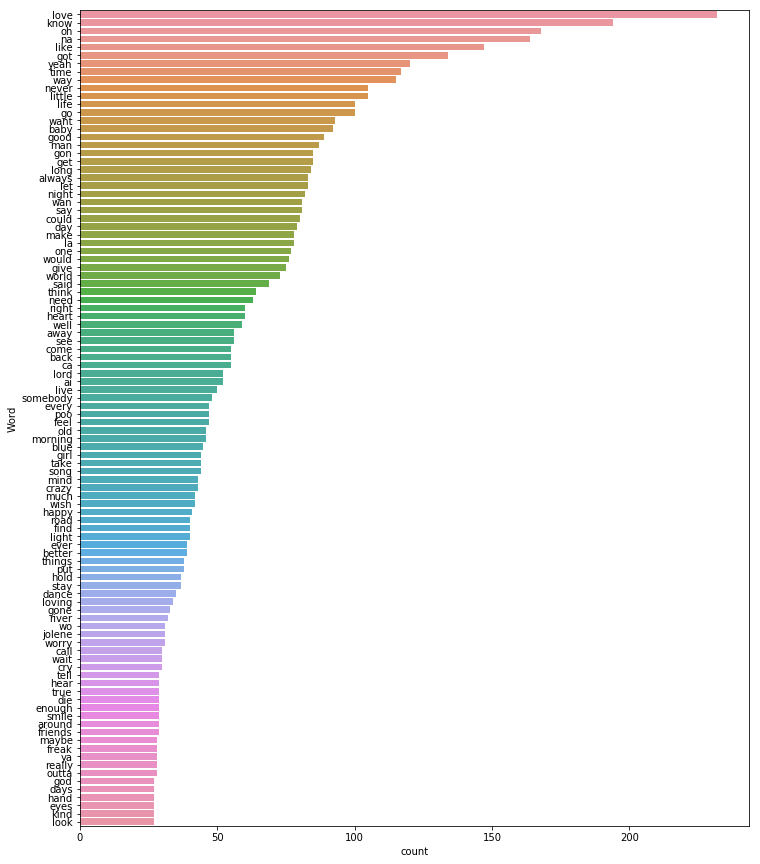

In [6]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
      # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

# print 100 most frequent words 
freq_words(songs.LYRICS, 100)

In [7]:
#extract topics
topics = []

for i in songs['Topics']: 
    topics.append(i.strip('][').split(', ')) 

#add to 'movies' dataframe 
songs['Topics'] = topics


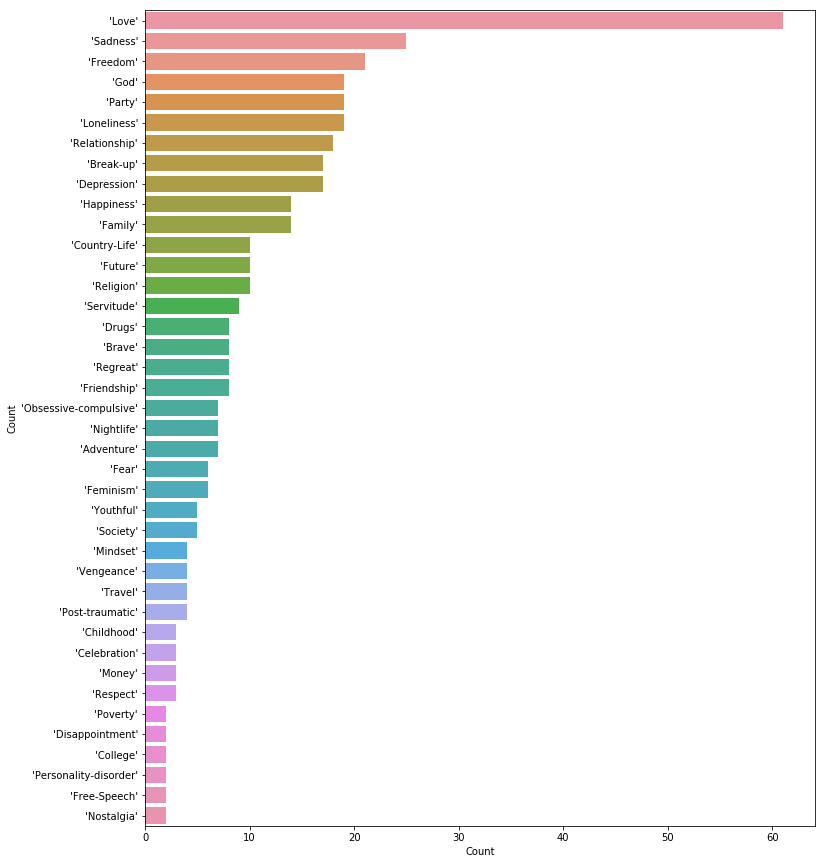

In [8]:
all_topics = sum(topics,[])
len(set(all_topics))

all_topics = nltk.FreqDist(all_topics) 

# create dataframe
all_topics_df = pd.DataFrame({'Genre': list(all_topics.keys()), 
                              'Count': list(all_topics.values())})

g = all_topics_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [9]:

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(songs['Topics'])

bestfeatures = SelectKBest(score_func=chi2, k=20)

# transform target variable
y = multilabel_binarizer.transform(songs['Topics'])
#X_new = SelectKBest(multilabel_binarizer, k=2).fit_transform(X, y)

tfidf_vectorizer = TfidfVectorizer(max_df=0.3, max_features=5000)

xtrain, xval, ytrain, yval = train_test_split(songs['LYRICS'], y, test_size=0.3, random_state=9)

# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)


In [10]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [11]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(xtrain_tfidf, ytrain)
y_pred = clf.predict(xval_tfidf)

print("F1 Score: " + str(f1_score(yval, y_pred, average="micro")))

multilabel_binarizer.inverse_transform(y_pred)

/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))


F1 Score: 0.03174603174603175


[(),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ("'Love'",),
 ("'Love'",),
 (),
 ("'Love'",),
 (),
 ()]

In [12]:
clf2_LinearSVC = OneVsRestClassifier(LinearSVC(random_state=0))
clf2_LinearSVC.fit(xtrain_tfidf, ytrain)
prediction_LinearSVC = clf2_LinearSVC.predict(xval_tfidf)

print("F1 Score: " + str(f1_score(yval, prediction_LinearSVC, average="micro")))

multilabel_binarizer.inverse_transform(prediction_LinearSVC)

F1 Score: 0.04545454545454545


/anaconda2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))


[(),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ("'Love'",),
 (),
 (),
 ("'Depression'", "'God'"),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ("'Happiness'", "'Love'", "'Relationship'"),
 ("'Love'",),
 ("'Love'",),
 ("'Love'",),
 (),
 ()]

In [13]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier_GaussianNB = BinaryRelevance(GaussianNB())
# train
classifier_GaussianNB.fit(xtrain_tfidf, ytrain)
# predict
predictions_GaussianNB = classifier_GaussianNB.predict(xval_tfidf)
# accuracy
print("F1 Score: " + str(f1_score(yval, predictions_GaussianNB, average="micro")))

multilabel_binarizer.inverse_transform(predictions_GaussianNB)

F1 Score: 0.0816326530612245


[("'Love'",),
 (),
 ("'Freedom'",),
 (),
 (),
 (),
 (),
 (),
 (),
 ("'Love'",),
 ("'Love'",),
 (),
 (),
 ("'Love'",),
 (),
 ("'God'",),
 ("'Freedom'", "'Love'"),
 (),
 ("'Love'",),
 (),
 ("'Depression'",),
 (),
 (),
 (),
 ("'Love'",),
 (),
 (),
 (),
 (),
 ("'Childhood'", "'Family'", "'God'", "'Happiness'", "'Love'"),
 ("'Love'",),
 (),
 ("'Love'",),
 ("'Happiness'", "'Love'", "'Relationship'"),
 (),
 ("'Love'",),
 ("'Sadness'",),
 ("'Freedom'",),
 ()]

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score
clf_MultinomialNB = OneVsRestClassifier(MultinomialNB())
clf_MultinomialNB.fit(xtrain_tfidf, ytrain)
pred_MultinomialNB = clf_MultinomialNB.predict(xval_tfidf)

#multilabel_binarizer.inverse_transform(pred)
print("F1 Score: " + str(f1_score(yval,pred_MultinomialNB,average='micro')))

multilabel_binarizer.inverse_transform(pred_MultinomialNB)

F1 Score: 0.03149606299212599


/anaconda2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))


[(),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ("'Love'",),
 ("'Love'",),
 ("'Love'",),
 ("'Love'",),
 (),
 ()]

In [34]:
classifier_MLkNN = MLkNN(k=1)
classifier_MLkNN.fit(xtrain_tfidf, ytrain)
# predict
predictions_MLkNN = classifier_MLkNN.predict(xval_tfidf)

print("F1 Score: " + str(f1_score(yval,predictions_MLkNN,average='micro')))
multilabel_binarizer.inverse_transform(predictions_MLkNN)


 F1 Score: 0.17142857142857143


[("'Love'", "'Relationship'"),
 ("'Adventure'", "'Family'", "'Future'"),
 ("'Brave'", "'Freedom'", "'Happiness'"),
 ("'Drugs'", "'Loneliness'", "'Party'", "'Sadness'"),
 ("'Freedom'", "'Happiness'", "'Society'"),
 ("'God'", "'Religion'", "'Servitude'"),
 ("'Country-Life'", "'Depression'", "'Loneliness'", "'Nostalgia'"),
 ("'Drugs'", "'Loneliness'", "'Party'", "'Sadness'"),
 ("'Break-up'", "'Sadness'"),
 ("'Love'", "'Relationship'"),
 ("'Fear'", "'Freedom'", "'Sadness'"),
 ("'Loneliness'", "'Party'"),
 ("'Feminism'", "'Love'", "'Mindset'", "'Relationship'", "'Youthful'"),
 ("'Feminism'", "'Love'", "'Mindset'", "'Relationship'", "'Youthful'"),
 ("'Loneliness'", "'Vengeance'"),
 ("'Depression'", "'God'", "'Religion'", "'Servitude'"),
 ("'Drugs'", "'Loneliness'", "'Party'", "'Sadness'"),
 ("'Adventure'", "'Love'", "'Post-traumatic'", "'Relationship'"),
 ("'Family'", "'Future'", "'Love'"),
 ("'Drugs'", "'Loneliness'", "'Party'", "'Sadness'"),
 ("'Brave'", "'Freedom'", "'Happiness'"),
 ("'Ad

In [23]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier_GaussianNB = LabelPowerset(GaussianNB())
#OR
#classifier = ClassifierChain(DecisionTreeClassifier())
# train
classifier_GaussianNB.fit(xtrain_tfidf, ytrain)
# predict
predictions_GaussianNB = classifier_GaussianNB.predict(xval_tfidf)
print("F1 Score: " + str(f1_score(yval, predictions_GaussianNB, average="micro")))

multilabel_binarizer.inverse_transform(predictions_GaussianNB)

F1 Score: 0.1962616822429907


[("'Love'", "'Relationship'"),
 ("'Love'", "'Relationship'"),
 ("'Nightlife'", "'Party'"),
 ("'Nightlife'", "'Party'"),
 ("'Love'", "'Relationship'"),
 ("'God'", "'Religion'", "'Servitude'"),
 ("'Nightlife'", "'Party'"),
 ("'God'", "'Religion'", "'Servitude'"),
 ("'Nightlife'", "'Party'"),
 ("'Love'", "'Relationship'"),
 ("'God'", "'Religion'", "'Servitude'"),
 ("'Nightlife'", "'Party'"),
 ("'Love'", "'Relationship'"),
 ("'Nightlife'", "'Party'"),
 ("'Nightlife'", "'Party'"),
 ("'Depression'", "'God'", "'Religion'", "'Servitude'"),
 ("'Nightlife'", "'Party'"),
 ("'Nightlife'", "'Party'"),
 ("'Break-up'", "'Loneliness'", "'Love'", "'Sadness'"),
 ("'Nightlife'", "'Party'"),
 ("'God'", "'Religion'", "'Servitude'"),
 ("'God'", "'Religion'", "'Servitude'"),
 ("'Nightlife'", "'Party'"),
 ("'Nightlife'", "'Party'"),
 ("'Love'", "'Relationship'"),
 ("'Break-up'", "'Loneliness'", "'Love'", "'Sadness'"),
 ("'Nightlife'", "'Party'"),
 ("'Nightlife'", "'Party'"),
 ("'Love'", "'Relationship'"),
 ("

In [25]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.tree import DecisionTreeClassifier
# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier use any other classifier if u wish
#classifier = ClassifierChain(GaussianNB())
classifier_DecisionTreeClassifier = ClassifierChain(DecisionTreeClassifier())
# train
classifier_DecisionTreeClassifier.fit(xtrain_tfidf, ytrain)
# predict
predictions_DecisionTreeClassifier = classifier_DecisionTreeClassifier.predict(xval_tfidf)
print("F1 Score: " + str(f1_score(yval, predictions_DecisionTreeClassifier, average="micro")))
multilabel_binarizer.inverse_transform(predictions_DecisionTreeClassifier)

F1 Score: 0.225


[("'Freedom'",),
 ("'Disappointment'",
  "'Free-Speech'",
  "'Loneliness'",
  "'Love'",
  "'Relationship'"),
 ("'Fear'", "'Freedom'"),
 ("'Depression'", "'Love'", "'Money'", "'Obsessive-compulsive'"),
 ("'Fear'", "'Loneliness'", "'Love'"),
 ("'Depression'", "'Family'", "'Future'", "'Regreat'"),
 ("'Loneliness'", "'Love'", "'Nostalgia'"),
 ("'Love'",),
 ("'Adventure'", "'Feminism'"),
 ("'Happiness'", "'Love'"),
 ("'Love'", "'Religion'"),
 ("'Depression'", "'Love'", "'Sadness'"),
 ("'Break-up'", "'Happiness'", "'Loneliness'", "'Love'"),
 ("'Freedom'", "'Obsessive-compulsive'"),
 ("'Family'", "'Love'", "'Relationship'"),
 ("'Fear'", "'Love'"),
 ("'Freedom'", "'Nightlife'"),
 ("'Brave'", "'Fear'", "'God'", "'Regreat'", "'Sadness'"),
 ("'Feminism'", "'Future'", "'God'", "'Servitude'"),
 ("'Love'", "'Party'"),
 ("'Love'",),
 (),
 ("'Depression'", "'Fear'"),
 ("'Break-up'", "'Childhood'", "'Love'", "'Sadness'"),
 ("'Brave'", "'Fear'", "'Freedom'"),
 ("'Brave'", "'Break-up'", "'Family'", "'Lon

In [41]:
def infer_tags_all(q):
    array_results = {}
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred_DecisionTreeClassifier = classifier_DecisionTreeClassifier.predict(q_vec)
    array_results['DecisionTree'] = multilabel_binarizer.inverse_transform(q_pred_DecisionTreeClassifier)

    
    q_pred_MLkNN = classifier_MLkNN.predict(q_vec)
    array_results['MLkNN'] = multilabel_binarizer.inverse_transform(q_pred_MLkNN)

    
    q_pred_GaussianNB = classifier_GaussianNB.predict(q_vec)
    array_results['GaussianNB'] = multilabel_binarizer.inverse_transform(q_pred_GaussianNB)
    
    return array_results



In [62]:


for i in range(20): 
    k = xval.sample(1).index[0] 
    tags = infer_tags_all(xval[k])
    print "Song: ", songs['TITLE'][k], "\nActual Topics: " + str(songs['Topics'][k])
    print "Predicted Topics: \nMLkNN: " + str(tags['MLkNN'])
    print "DecisionTree: ", tags['DecisionTree']
    print "GaussianNB: ", tags['GaussianNB'], "\n\n"
    
    

Song:   A Mothers Love  
Actual Topics: ["'Love'", "'Family'", "'Freedom'", "'Friendship'"]
Predicted Topics: 
MLkNN: [("'Depression'", "'God'", "'Religion'", "'Servitude'")]
DecisionTree:  [("'Fear'", "'Love'")]
GaussianNB:  [("'Depression'", "'God'", "'Religion'", "'Servitude'")] 


Song:   I'm Ready  
Actual Topics: ["'Respect'", "'Happiness'", "'Love'"]
Predicted Topics: 
MLkNN: [("'Depression'", "'Love'", "'Sadness'")]
DecisionTree:  [("'Disappointment'", "'Loneliness'", "'Love'", "'Party'", "'Sadness'")]
GaussianNB:  [("'Nightlife'", "'Party'")] 


Song:   I'm Ready  
Actual Topics: ["'Respect'", "'Happiness'", "'Love'"]
Predicted Topics: 
MLkNN: [("'Depression'", "'Love'", "'Sadness'")]
DecisionTree:  [("'Disappointment'", "'Loneliness'", "'Love'", "'Party'", "'Sadness'")]
GaussianNB:  [("'Nightlife'", "'Party'")] 


Song:   Have Yourself a Merry Little Christmas  
Actual Topics: ["'Family'", "'God'", "'Celebration'"]
Predicted Topics: 
MLkNN: [("'Country-Life'", "'Depression'",

In [39]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = classifier_GaussianNB.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

for i in range(20): 
    k = xval.sample(1).index[0] 
    print "Song: ", songs['TITLE'][k], "\nPredicted Topics: ", infer_tags(xval[k])
    print "Actual Topics: " + str(songs['Topics'][k]), "\n"

Song:   I'm Ready  
Predicted Topics:  [("'Nightlife'", "'Party'")]
Actual Topics: ["'Respect'", "'Happiness'", "'Love'"] 

Song:   Have Yourself a Merry Little Christmas  
Predicted Topics:  [("'Nightlife'", "'Party'")]
Actual Topics: ["'Family'", "'God'", "'Celebration'"] 

Song:   Forevermore  
Predicted Topics:  [("'Love'", "'Relationship'")]
Actual Topics: ["'Loneliness'", "'Love'", "'Happiness'"] 

Song:   Mom  
Predicted Topics:  [("'Nightlife'", "'Party'")]
Actual Topics: ["'Family'", "'God'", "'Love'"] 

Song:   Set You Free  
Predicted Topics:  [("'Break-up'", "'Loneliness'", "'Love'", "'Sadness'")]
Actual Topics: ["'Sadness'", "'Break-up'", "'Love'"] 

Song:   Before He Cheats  
Predicted Topics:  [("'Nightlife'", "'Party'")]
Actual Topics: ["'Regreat'", "'Vengeance'", "'Love'", "'Party'", "'Nightlife'"] 

Song:   I'm My Own Grandpa  
Predicted Topics:  [("'God'", "'Religion'", "'Servitude'")]
Actual Topics: ["'Love'"] 

Song:   Have Yourself a Merry Little Christmas  
Predi